<img src='./img/c3s_header.png' align='right' width='100%'></img>

<br>

# Visualize the bias of seasonal forecast data

### About

This notebook will show you how you how you can visualize the bias of real-time seasonal forecasts of global sea surface temperature. 

#### Model errors
Seasonal forecasts are started from an observed state of (all components of) the climate system, which is then evolved in time over a period of a few months. Errors present at the start of the forecast (due to the imprecise measurement of the initial conditions and the approximations assumed in the formulation of the models) persist or, more often, grow through the model integration.

#### Biases and hindcasts
Some errors are random, some errors, however, are systematic. If these systematic errors were determined, corrections could be applied to the forecasts to extract the useful information. This is achieved by comparing retrospective forecasts (reforecasts or `hindcasts`) with observations. By building the average of the `hindcasts`, you can identify a 'climate' (average over a reference period, e.g 1993 to 2016) of the model, which can then be compared with the observed climate of the real world. The systematic differences between the model and the real world - usually referred to as `biases` - are thus quantified and used as the basis for corrections which can be applied to future, real-time forecasts.  Given the relative magnitude of such biases, some basic corrections are essential to convert the data into forecast information - therefore a forecast by itself is not useful without relating it to the relevant hindcasts.

To compute the real-world climate, the example below will make use of [ERA5 monthly averages on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview).


The notebook has the following outline:
* [1 - Request data from the CDS programmatically with the CDS API](#request_data_seasonal_2)
* [2 - Compute the hindcast climate mean and variance for reference period 1993 to 2016](#hindcast_climate_mean_bias)
* [3 - Compute observation climate mean and variance from ERA5 monthly averages for reference period 1993 to 2016](#observation_climate_mean_bias)
* [4 - Load real-time seasonal forecast for September 2021 and five leadtime months](#load_realtime_forecast_bias)
* [5 - Visualize the bias between seasonal real-time forecast, model climate and observed climate](#visualize_bias)

### Data

This notebook makes use of [seasonal forecast monthly statistics](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=overview) (hindcasts and real-time forecasts) and [ERA5 monthly averaged data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). The data used in the notebook has the following specifications:


> **Data**: `Seasonal forecast monthly statistics on single levels - Hindcast data` <br>
> **Temporal coverage**: `Sep 1993 to Sep 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve requests

> **Data**: `Seasonal forecast monthly statistics on single levels - Forecast data` <br>
> **Temporal coverage**: `Sep 2021` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`

> **Data**: `ERA5 monthly averaged data on single levels` <br>
> **Temporal coverage**: `Sep, Oct, Nov, Dec, Jan and Feb from 1993 to 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`


### How to access the notebook
* [**nbviewer**](https://nbviewer.org/github/ecmwf-projects/copernicus-training/blob/master/122_c3s_seasonal_forecasts_bias_visualisation.ipynb)
* [**Colab**](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/122_c3s_seasonal_forecasts_bias_visualisation.ipynb)
* [**Binder**](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/122_c3s_seasonal_forecasts_bias_visualisation.ipynb)
* [**Kaggle**](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/122_c3s_seasonal_forecasts_bias_visualisation.ipynb)

### Further resources
* [Seasonal forecasts and the Copernicus Climate Change Service](https://confluence.ecmwf.int/display/CKB/Seasonal+forecasts+and+the+Copernicus+Climate+Change+Service)

<hr>

### Install CDS API via pip

In [ ]:
!pip install cdsapi

### Load libraries

In [30]:
# CDS API
import cdsapi
import warnings

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

warnings.simplefilter(action = "ignore", category = RuntimeWarning)

<hr>

## <a id='request_data_climatologies'></a> 1. Request data from the CDS programmatically with the CDS API

The first step is to request data from the Climate Data Store programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal CDS key. Please find [here](https://cds.climate.copernicus.eu/api-how-to) your personal CDS key.

In [39]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '#######################'

<br>

The next step is then to request the data with the help of the CDS API. Below, we request three different datasets:
* **Seasonal forecast monthly statistics on single levels - Retrospective forecasts (Hindcasts)**: Sea surface temperature for month September from 1993 to 2016 for six lead time months
* **Seasonal forecast monthly statistics on single levels - Forecasts**: Sea surface temperature for September 2021 and six lead time months
* **ERA5 monthly averaged data on single levels**: Sea surface temperature for months Jan, Feb, Sep, Oct, Nov, Dec for 1993 to 2016 

Seasonal forecast data are disseminated in the GRIB data format. Let us store the data in the main working directory with the names `ecmwf_seas5_1993-2016_09_hindcast_monthly_sst.grib`, `ecmwf_seas5_2021_09_forecast_monthly_sst.grib` and `era5_monthly_1993-2016_sep-feb_sst.grib`.

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': 'sea_surface_temperature',
        'product_type': 'monthly_mean',
        'year': [
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2005', '2006', '2007',
            '2008', '2009', '2010',
            '2011', '2012', '2013',
            '2014', '2015', '2016',
        ],
        'month': '09',
        'leadtime_month': [
            '1', '2', '3',
            '4', '5', '6',
        ],
    },
    './ecmwf_seas5_1993-2016_09_hindcast_monthly_sst.grib')

c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': 'sea_surface_temperature',
        'product_type': 'monthly_mean',
        'year': '2021',
        'month': '09',
        'leadtime_month': [
            '1', '2', '3',
            '4', '5', '6',
        ],
    },
    './ecmwf_seas5_2021_09_forecast_monthly_sst.grib')

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'sea_surface_temperature',
        'year': [
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2005', '2006', '2007',
            '2008', '2009', '2010',
            '2011', '2012', '2013',
            '2014', '2015', '2016',
        ],
        'month': [
            '01', '02', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'format': 'grib',
    },
    './era5_monthly_1993-2016_sep-feb_sst.grib')

<br>

## <a id='hindcast_climate_mean_bias'></a>2. Compute the hindcast climate mean and variance for reference period 1993 to 2016

The first step is load the global hindcast data for September from 1993 to 2016 and calculate the `mean` and `variance` of the hindcast climate, based on the reference period 1993 to 2016. 

The seasonal forecasts monthly statistics are available in the data format `GRIB`, which can be opened with the Python package [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()`. In order to be able to open `GRIB` file, you have to specify the keyword argument `engine='cfgrib'`, which makes use of [cfgrib](https://github.com/ecmwf/cfgrib), a Python interface to map GRIB to the NetCDF Common Data model.

You can specify a custom data structure by identifying the keyword argument `backend_kwargs` and specifically highligting the two dimensions that shall be used for the time dimensions. When you do this, you see that the resulting `xarray.Dataset` has five dimensions:
* `number`: Number of ensembles (25)
* `forecastMonth`: leadtime months (6, including the startime run)
* `time`: number of years (24, from 1993 to 2016)
* `latitude`: latitudes (181 -> 1 deg resolution)
* `longitude`: longitudes (360 --> 1 deg resolution)

In [9]:
ds_hindcast = xr.open_dataset('./ecmwf_seas5_1993-2016_09_hindcast_monthly_sst.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
ds_hindcast

<xarray.Dataset>
Dimensions:        (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    sst            (number, forecastMonth, time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-23T16:33 GRIB to CDM+CF via cfgrib-0.9.9...

The next step is to load the data variable `sst` as `xarray.DataArray`. You can load a DataArray from a Dataset by specifying the name of the variable in square brackets `[]`. A `xarray.DataArray` provides you additional attributes of the variable. For example, you see that the sea surface temperature is provided in the unit `Kelvin`.

In [10]:
sst_hindcast = ds_hindcast['sst']
sst_hindcast

<xarray.DataArray 'sst' (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)>
[234576000 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes:
    GRIB_paramId:                             34
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           sst
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_iDirectionIncrementInDegrees:        1.0
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        1.0
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.0
    GRIB_missingValue:                        9999
    GRIB_name:                                Sea surface temperature
    GRIB_shortName:                           sst
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

Since we are interested in creating the `hindcast climate mean`, the next step is to create the average over the 25 ensemble members and the 24 start years. You can use the function `mean()` in order to average over one or more given dimensions. The dimension we want to create the longterm mean are `number` (25 ensemble members) and `time` (start time years from 1993 to 2016). The result is a `xarray.DataArray` with three dimensions: `forecastMonth`, `latitude` and `longitude`.

The data array `sst_hindcast_mean` is the hindcast climate mean for the month September and five leadtime months, over the reference period 1993 to 2016.

**Note:** with the averaging operation, your `xarray.DataArray` loses its attributes. At the end, we will again add the attributes.

In [11]:
sst_hindcast_mean = sst_hindcast.mean(['number', 'time'])
sst_hindcast_mean

<xarray.DataArray 'sst' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[271.38278, 271.38278, 271.38278, ..., 271.38278, 271.38278,
         271.38278],
        [271.3829 , 271.383  , 271.38315, ..., 271.3826 , 271.38266,
         271.38284],
        [271.38742, 271.38782, 271.38818, ..., 271.3865 , 271.38678,
         271.38702],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.34988, 271.34988, 271.34988, ..., 271.34988, 271.34988,
         271.34988],
        [271.35007, 271.35013, 271.35013, ..., 271.35007, 271.35007,
         271.35007],
        [271.35056, 271.35056, 271.35056, ..., 271.35056, 271.3506 ,
         271.3506 ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        [271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        [271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

The next step is also to calculate the variance of the hindcast climate mean. Instead of the function `mean()`, we can use the function `var()`, which computes the variance over the 25 ensemble members and the 24 start years. The resulting xarray.DataArray `sst_hindcast_variance` has three dimensions: `forecastMonth`, `latitude` and `longitude`. We will need the variance later on when we correct the bias of the forecast data.

In [12]:
sst_hindcast_variance = sst_hindcast.var(['number', 'time'])
sst_hindcast_variance

<xarray.DataArray 'sst' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[1.9864733e-03, 1.9864733e-03, 1.9864733e-03, ...,
         1.9864733e-03, 1.9864733e-03, 1.9864733e-03],
        [2.0455327e-03, 2.0600969e-03, 2.0772023e-03, ...,
         1.9969535e-03, 2.0109811e-03, 2.0267235e-03],
        [2.5749102e-03, 2.6136623e-03, 2.6538339e-03, ...,
         2.4352488e-03, 2.4787856e-03, 2.5270651e-03],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[4.9087776e-06, 4.9087776e-06, 4.9087776e-06, ...,
         4.9087776e-06, 4.9087776e-06, 4.9087776e-06],
        [8.8985144e-06, 8.7972858e-06, 8.7369854e-06, ...,
         8.8633469e-06, 8.8252000e-06, 8.9112300e-06],
        [2.9411360e-05, 2.8977536e-05, 2.8974557e-05, ...,
         2.9754205e-05, 2.9549599e-05, 2.9670397e-05],
...
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        [3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        [3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

We have now loaded and computed the hindcast climate mean. The next step is to calculate the climate mean from observations, which is used as the observation climate mean.

<br>

## <a id='observation_climate_mean_bias'></a>3. Compute observation climate mean and variance from ERA5 monthly averages for reference period 1993 to 2016

The second step is to compute the climate mean and variance from observations, for the same reference period, from 1993 to 2016. As observation data, we make use of ERA5 monthly averages on single levels.
ERA5 data is a reanalysis and the data structure differs from seasonal forecast data. Instead of leadtime months, we select monthly averages for the months September to February for each year, from 1993 to 2016. You can use the function `open_dataset()` together with the keyword argument `engine='cfgrib'` to open the GRIB file. Here, you do not have to specify specific keys to load, as reanalysis data do not have two time dimensions. If you load the GRIB file, you see that the data is structure in three dimensions: 
* `time`: 144 entries for months Jan, Feb, Sep, Oct, Nov, Dec from 1993 to 2016
* `latitude`: latitude (721 --> 0.25 deg)
* `longitude`: longitude (1440 --> 0.25 deg)

In [14]:
ds_observation = xr.open_dataset('./era5_monthly_1993-2016_sep-feb_sst.grib', engine='cfgrib')
ds_observation

<xarray.Dataset>
Dimensions:     (time: 144, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] ...
Data variables:
    sst         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-23T16:37 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

The next step is to load from the dataset above the data variable `sst` as xarray.DataArray. You simply add the name of the data variable in square brackets `[]`.

In [15]:
sst_observation = ds_observation['sst']
sst_observation

<xarray.DataArray 'sst' (time: 144, latitude: 721, longitude: 1440)>
[149506560 values with dtype=float32]
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Attributes:
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           sst
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_iDirectionIncrementInDegrees:        0.25
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.25
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.75
    GRIB_missingValue:                        9999
    GRIB_name:                                Sea surface temperature
    GRIB_shortName:                           sst
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

The next step is now to create the average for each month for the reference period. You can use the function `group_by()` to specify the dimension you would to build groups from. In the present example, we want to build groups for each month in the `time` dimension. With the function `mean()` you can apply an aggregator function on the defined groups. The resulting data array has three dimensions, but the dimension `time` which has previously 144 entries changed to `month` with six entries.

In [16]:
sst_observation_mean = sst_observation.groupby('time.month').mean()
sst_observation_mean

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[271.4601 , 271.4601 , 271.4601 , ..., 271.4601 , 271.4601 ,
         271.4601 ],
        [271.4601 , 271.46008, 271.4601 , ..., 271.4601 , 271.4601 ,
         271.4601 ],
        [271.4601 , 271.4601 , 271.4601 , ..., 271.46008, 271.4601 ,
         271.4601 ],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        [271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        [271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * month      (month) int64 1 2 9 10 11 12

Let us repeat the same procedure as above, but instead of the average, let us compute the variance with the function `var()`. We will need the variance later on when we correct the bias of the forecast data.

In [17]:
sst_observation_var = sst_observation.groupby('time.month').var()
sst_observation_var

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[7.97832982e-08, 7.97832982e-08, 7.97832982e-08, ...,
         7.97832982e-08, 7.97832982e-08, 7.97832982e-08],
        [7.97832982e-08, 6.95387499e-08, 7.97832982e-08, ...,
         7.97832982e-08, 7.97832982e-08, 7.97832982e-08],
        [7.97832982e-08, 7.97832982e-08, 7.97832982e-08, ...,
         1.09275184e-07, 7.97832982e-08, 7.97832982e-08],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
        [8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
        [8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        [6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        [6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * month      (month) int64 1 2 9 10 11 12

In the data arrays above, you see that the month dimension is organized based on the sequence of a year. This means, that values for January and February are before the values for Sep, Oct, Nov and Dec. In order to organise the observation data arrays in the same way as the seasonal forecast data, we first can create a list of forecast months.

In [32]:
start_month = pd.to_datetime(sst_hindcast.time.values[0]).month
fcmonths = [mm+1 if mm>=0 else mm+13 for mm in sst_observation_mean.month.values - start_month]
fcmonths

[5, 6, 1, 2, 3, 4]

In a next step, we assign a new dimension called `forecastMonth` to the two data array `sst_observation_mean` and `sst_observation_var`. This dimension holds the list of forecast months created above. With the function `sortby()`, the order of the observations data can be re-organized based on how the seasonal forecast data organisation.

In [33]:
sst_observation_mean_roll = sst_observation_mean.assign_coords(forecastMonth=('month',fcmonths)).sortby('forecastMonth')
sst_observation_var_roll = sst_observation_var.assign_coords(forecastMonth=('month',fcmonths)).sortby('forecastMonth')
sst_observation_mean_roll

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[271.46005, 271.46005, 271.46005, ..., 271.46005, 271.46005,
         271.46005],
        [271.46   , 271.46   , 271.46   , ..., 271.46   , 271.46   ,
         271.46   ],
        [271.46   , 271.45996, 271.45996, ..., 271.45996, 271.46   ,
         271.45996],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.4602 , 271.4602 , 271.4602 , ..., 271.4602 , 271.4602 ,
         271.4602 ],
        [271.4602 , 271.4601 , 271.4602 , ..., 271.4602 , 271.4602 ,
         271.4602 ],
        [271.4602 , 271.4602 , 271.4602 , ..., 271.4602 , 271.4602 ,
         271.4602 ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    number         int64 0
    step           timedelta64[ns] 00:00:00
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * month          (month) int64 9 10 11 12 1 2
    forecastMonth  (month) int64 1 2 3 4 5 6

Now, we have also loaded and computed the climate mean and variance of the ERA5 observation data. The next step is now to load real-time seasonal forecast data for September 2021 and five leadtime months.

## <a id='load_realtime_forecast_bias'></a>4. Load real-time seasonal forecast for September 2021 and five leadtime months

The next step is now to load real-time seasonal forecasts for September 2021 and five leadtime months till February 2021. We open the dataset `ecmwf_seas5_2021_09_forecast_monthly_sst.grib` with the xarray function `open_dataset()`, where we again specify the two keyword arguments `engine` and `backend_kwargs`.

Once the `xarray.Dataset` is loaded, you see that it has 4 dimensions:
* `number`: 51 ensemble members
* `forecastMonth`: 6 leadtime months, including September, the month of the model run
* `latitude`: latitude values
* `longitude`: longitude values

Compared to the hindcast data, we do not have the dimension `time`, as the data only holds information for the year 2021. Another difference is that seasonal forecast real-time data have 51 ensemble members, compared to hindcasts, who only have 25 ensemble members.

In [19]:
ds_forecast = xr.open_dataset('./ecmwf_seas5_2021_09_forecast_monthly_sst.grib', 
                              engine='cfgrib', 
                              backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
ds_forecast

<xarray.Dataset>
Dimensions:        (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    sst            (number, forecastMonth, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-23T16:39 GRIB to CDM+CF via cfgrib-0.9.9...

Now, let us load the data variable `sst` as xarray.DataArray from the loaded dataset above.

In [20]:
sst_forecast = ds_forecast['sst']
sst_forecast

<xarray.DataArray 'sst' (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)>
[19938960 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes:
    GRIB_paramId:                             34
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           sst
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_iDirectionIncrementInDegrees:        1.0
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        1.0
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.0
    GRIB_missingValue:                        9999
    GRIB_name:                                Sea surface temperature
    GRIB_shortName:                           sst
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

The next step is now to visualize the bias between seasonal real-time forecast, model climate and observed climate.

## <a id='visualize_bias'></a>5. Visualize the bias between seasonal real-time forecast, model climate and observed climate

Now, we have all the data we need to assess the bias of the forecast. The following data were loaded:
* `sst_observation_mean_roll`: the average conditions *observed* during the months Sep to Feb
* `sst_hindcast_mean`: the model climate during the months Sep to Feb
* `sst_forecast`: the seasonal forecast for Sep 2021 and 5 leadtime months

The next step is to visually represent the bias. This representation will help us to better understand whether the model produces a cold (underpredicts) or warm bias (overpredicts). Let us investigate the bias for the sea surface temperature of the region Nino 3.4.

First, let us define a function (`ds_latlon_subset`) that allows us to create a geographical subset from a data array. We further also specify the bounding box coordinates for the Nino 3.4 region.

In [21]:
def ds_latlon_subset(ds,area,latname='latitude',lonname='longitude'):
    
    mask = (ds[latname]<=area[0]) & (ds[latname]>=area[2]) & (ds[lonname]<=area[3]%360) & (ds[lonname]>=area[1]%360)
    dsout = ds.where(mask,drop=True)
    
    return dsout

In [22]:
NINO34 = (5,-170,-5,-120) #'North/West/South/East' 

<br>

#### Create a dataframe of the sea surface temperature observations for the Nino 3.4 region

Based on the computed variances of the sea surace temperature observations, you can create the upper and lower boundaries.

In [34]:
sst_observation_upper = sst_observation_mean_roll + np.sqrt(sst_observation_var_roll)
sst_observation_lower = sst_observation_mean_roll - np.sqrt(sst_observation_var_roll)
sst_observation_lower

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[271.45956, 271.45956, 271.45956, ..., 271.45956, 271.45956,
         271.45956],
        [271.4595 , 271.4595 , 271.4595 , ..., 271.4595 , 271.4595 ,
         271.4595 ],
        [271.4595 , 271.45953, 271.45953, ..., 271.45947, 271.4595 ,
         271.45953],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.4598 , 271.4598 , 271.4598 , ..., 271.4598 , 271.4598 ,
         271.4598 ],
        [271.4598 , 271.4598 , 271.4598 , ..., 271.4598 , 271.4598 ,
         271.4598 ],
        [271.4598 , 271.4598 , 271.4598 , ..., 271.4598 , 271.4598 ,
         271.4598 ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.45978, 271.45978, 271.45978, ..., 271.45978, 271.45978,
         271.45978],
        [271.45978, 271.45978, 271.45978, ..., 271.45978, 271.45978,
         271.45978],
        [271.45978, 271.45978, 271.45978, ..., 271.45978, 271.45978,
         271.45978],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    number         int64 0
    step           timedelta64[ns] 00:00:00
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * month          (month) int64 9 10 11 12 1 2
    forecastMonth  (month) int64 1 2 3 4 5 6

In a next step, let us create for both, the upper and lower bounds of the observations, first a geographical subset for the Nino 3.4 region with the function `ds_latlon_subset()`. In a subsequent step, create then an average over the geographical region and convert the data array to a pandas.DataFrame with the function `to_dataframe()`.

In [36]:
thisobs = ds_latlon_subset(sst_observation_upper,NINO34)
obs_NINO34_upper = thisobs.mean(['latitude','longitude']).drop_vars(['number','step','surface']).to_dataframe().set_index('forecastMonth')

thisobs = ds_latlon_subset(sst_observation_lower,NINO34)
obs_NINO34_lower = thisobs.mean(['latitude','longitude']).drop_vars(['number','step','surface']).to_dataframe().set_index('forecastMonth')

Now, we also create a geographical subset for the average sea surface temperature observations. Afterwards, create a pandas.Dataframe with the SST values averaged over the entire geographical domain. The result is a simple data frame with six rows and one column.

In [24]:
obs_NINO34 = ds_latlon_subset(sst_observation_mean_roll,NINO34)
obs_NINO34_mean = obs_NINO34.mean(['latitude','longitude']).drop_vars(['number','step','surface']).to_dataframe()
obs_NINO34_mean = obs_NINO34_mean.set_index('forecastMonth')
obs_NINO34_mean

,sst
forecastMonth,
1,299.895782
2,299.886475
3,299.892883
4,299.691071
5,299.564117
6,299.737671


#### Create a dataframe of the sea surface temperature hindcasts for the Nino 3.4 region

Let us repeat the same procedure as done for the observation data also for the sea surface temperature hindcasts. First, we compute the 34th and 68th percentiles and use these as upper and lower bounds of the hindcast data.

In [ ]:
sst_hindcast_lower = sst_hindcast.quantile(0.34,['number', 'time'])
sst_hindcast_upper = sst_hindcast.quantile(0.68,['number', 'time'])

In a next step, we then create first a geogaphical subset of the Nino 3.4 region with the function `ds_latlon_subset()`. Afterwards, we compute the average sea surface temperature hindcast over the whole geographical domain and convert the data array into a pandas.Dataframe with the function `to_dataframe()`.

In [26]:
hcst_NINO34 = ds_latlon_subset(sst_hindcast_upper,NINO34)
hcst_NINO34_upper = hcst_NINO34.mean(['latitude','longitude']).drop_vars('quantile').to_dataframe()

hcst_NINO34 = ds_latlon_subset(sst_hindcast_lower,NINO34)
hcst_NINO34_lower = hcst_NINO34.mean(['latitude','longitude']).drop_vars('quantile').to_dataframe()

We also need to create a geographical subset for the average sea surface temperature hindcasts. Afterwards, we create a pandas.Dataframe with the SST values averaged over the entire geographical domain. The result is a simple data frame with six rows and one column.

In [25]:
hcst_NINO34 = ds_latlon_subset(sst_hindcast_mean,NINO34)
hcst_NINO34_mean = hcst_NINO34.mean(['latitude','longitude']).drop_vars('surface').to_dataframe()
hcst_NINO34_mean

,sst
forecastMonth,
1,299.922668
2,299.879120
3,299.816284
4,299.721832
5,299.676056
6,299.748932


#### Create a dataframe of the sea surface temperature forecasts for the Nino 3.4 region

In a last step before visualizing the seasonal forecast bias, we also need to generate a geographical subset of the Nino 3.4 region for the seasonal forecast data. Afterwards, we also compute the average of the forecast data over the entire geographical domain and convert the data array to a pandas.Dataframe with the function `to_dataframe()`.

Since the seasonal forecast data have 51 ensemble members, the last step is to `unstack()` the pandas.Dataframe, which transposes the values. The final data frame has six rows and 51 columnes, representing the 51 ensemble members.

In [37]:
fcst_NINO34 = ds_latlon_subset(sst_forecast,NINO34)
fcst_NINO34_mean = fcst_NINO34.mean(['latitude','longitude']).drop_vars(['time','surface']).to_dataframe(dim_order=['forecastMonth','number'])
fcst_NINO34_mean = fcst_NINO34_mean.unstack()
fcst_NINO34_mean

sst                                                  \
number                 0           1           2           3           4    
forecastMonth                                                               
1              299.587952  299.641113  299.587128  299.574036  299.575073   
2              299.445923  299.392517  299.403229  299.409149  299.295013   
3              299.184784  299.173676  299.342682  299.156738  299.143524   
4              299.000275  299.197235  299.314240  298.976044  299.139862   
5              298.900024  299.238251  299.372894  299.302460  299.399658   
6              299.294220  299.684784  299.686005  299.687897  299.558258   

                                                                           \
number                 5           6           7           8           9    
forecastMonth                                                               
1              299.628357  299.591278  299.626984  299.599976  299.664703   
2              299.096985  299.372345  299.307159  299.534302  299.417023   
3              298.913116  298.999329  299.050079  299.499969  299.179138   
4              299.137970  299.039368  298.859894  299.390442  299.124847   
5              299.326050  299.154297  298.686401  299.332764  299.402313   
6              299.608459  299.192627  298.847870  299.563293  299.741577   

               ...                                                  \
number         ...          41          42          43          44   
forecastMonth  ...                                                   
1              ...  299.593536  299.646118  299.591583  299.592926   
2              ...  299.362701  299.514709  299.360687  299.116577   
3              ...  298.860565  299.251160  298.962860  298.775635   
4              ...  298.778198  299.353943  298.649170  298.719818   
5              ...  298.906982  299.479950  298.761932  298.951050   
6              ...  299.158264  299.832733  299.084595  299.206512   

                                                                           \
number                 45          46          47          48          49   
forecastMonth                                                               
1              299.599060  299.596008  299.680450  299.522278  299.642731   
2              299.421082  299.350983  299.353882  299.151337  299.636505   
3              299.367981  299.142700  299.156403  299.012878  299.273346   
4              299.129456  299.051514  298.902832  298.804291  299.097321   
5              299.053406  299.234344  298.976776  298.921082  299.383179   
6              299.285278  299.541046  299.158325  299.280304  299.554016   

                           
number                 50  
forecastMonth              
1              299.728485  
2              299.571960  
3              299.418549  
4              299.283020  
5              299.213165  
6              299.394104  

[6 rows x 51 columns]

#### Visualize the bias of sea surface temperature forecasts of the Nino 3.4 region

Now, we can finally visualize the sea surface temperature forecasts of the Nino 3.4 region from September 2021 to February 2022 and compare the forecasts with the model climate and the observed climate. The matplotlib code for visualising the forecast bias can be split into four main parts:

* **1. Plot initiation**: Define size of the plot and initiate a subplot area with `plt.subplot()`

* **2. Plotting functions**: 
  * `plot()`: Time-series plot of model climate, observed climate and 51 ensemble of seasonal forecasts


* **3. Set labels and title**: Set name of x- and y-axis as well as title of the plot

* **4. Customize features**: Apply additional features to customized the style of the plot, e.g. size of x- and y-ticks or add gridlines

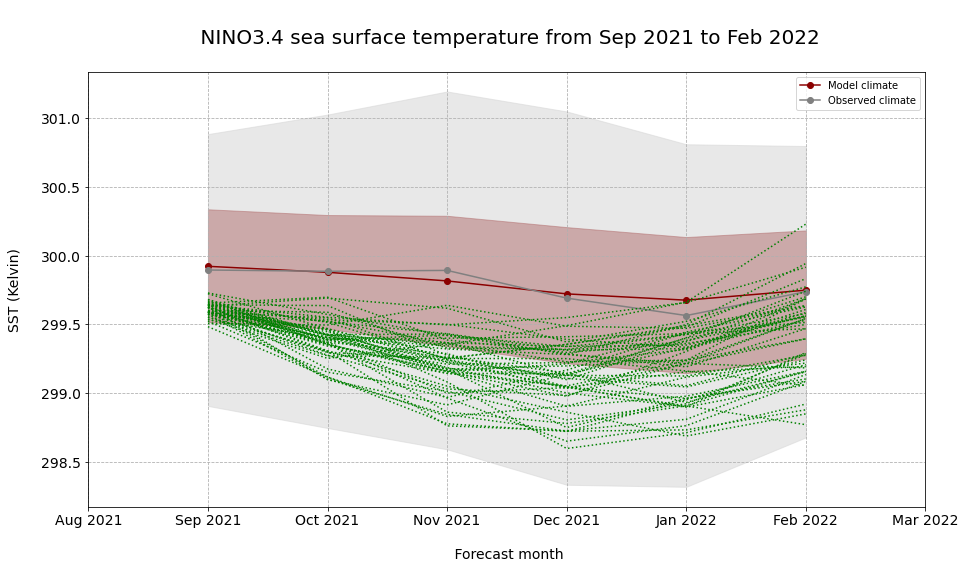

In [38]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Plot the model and obseved climate means of global sea surface temperature
ax.plot(hcst_NINO34_mean.sst, 'bo-', color='darkred', label='Model climate')
ax.fill_between(hcst_NINO34_upper.index,hcst_NINO34_lower.sst,hcst_NINO34_upper.sst, color='darkred', alpha=0.5)

ax.plot(obs_NINO34_mean.sst, 'bo-', color='grey', label= 'Observed climate')
ax.fill_between(obs_NINO34_upper.index,obs_NINO34_lower.sst,obs_NINO34_upper.sst, color='lightgrey', alpha=0.5)

ax.legend(fontsize=16,loc=2)

# Plot the global sea surface temperature forecasts for the 51 ensemble members
fcst_NINO34_mean.plot(ax=ax,
                             linestyle='dotted', color='green', legend=False, label='')

# Customize the title and axes lables
ax.set_title('\n NINO3.4 sea surface temperature from Sep 2021 to Feb 2022\n', fontsize=20)
ax.set_ylabel('SST (Kelvin)\n', fontsize=14)
ax.set_xlabel('\n Forecast month', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

locs,labels = plt.xticks()
newlabels = [(pd.to_datetime(fcst_NINO34.time.values)+relativedelta(months=int(fcmonth)-1)).strftime('%b %Y') for fcmonth in locs]
plt.xticks(locs,newlabels)

# Add a gridline to the plot
ax.grid(linestyle='--')

<br>

The graph above shows you the crucial role of hindcasts in seasonal forecasting. The grey line represents the average observed conditions and the red line represents the equivalent model climate average. The ensemble forecasts are shown as green lines, which indicate a cold bias, compared to both, the model climate and the observed climate. This visual representation shows you that a forecast by itself is not useful without relating it to the relevant hindcasts.

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>